In [1]:
import numpy as np

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 4
START = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == START:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state


In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]  # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3
        self.exp_rate = .3
        self.decay_gamma = 0.9
        self.Q_values = {}  # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS):
                t.append(False)
            self.past_all.append(t)

        self.steps = []
        self.stop = False
        self.states = []

    def optimal_action(self):
        max_value = -10000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action

    def get_actions(self):
        i, j = self.State.state[0], self.State.state[1]
        potential_position = []
        if i + 1 < BOARD_ROWS:
            potential_position.append("down")
        if i - 1 > 0:
            potential_position.append("up")
        if j + 1 < BOARD_COLS:
            potential_position.append("right")
        if j - 1 > 0:
            potential_position.append("left")
        return potential_position

    def get_action(self):
        """
        The agent should choose randomly among the positions that have
        not been visited, and if all possible positions are visited,
        then move randomly and receive a negative reward
        """
        actions = self.get_actions()
        if np.random.uniform(0, 1) <= self.exp_rate:
            b = True
            for a in actions:
                position = self.State.next_position(a)
                if self.past_all[position[0]][position[1]] is False:
                    b = False
            if b:
                action = np.random.choice(actions)
                return action
            # Else try to get an available unvisited position randomly
            else:
                while True:
                    action = np.random.choice(actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] is False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()

    def give_reward(self):
        reward = 0
        if self.State.state == START and self.check_all_past():
            reward += 10
        return reward

    def set_action(self, action):
        next_state = self.State.next_position(self.get_action())
        # self.State = State(state=next_state)
        return State(state=next_state)

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
        self.stop = False
        self.states = []

    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=1000):
        print("Training...")
        i = 1
        while i <= rounds:
            if self.stop:
                if self.is_end and self.check_all_past():
                    reward = 1
                else:
                    reward = -1
                for a in self.actions:
                    self.Q_values[self.State.state][a] = reward
                for s in reversed(self.states):
                    current_q_value = self.Q_values[s[0]][s[1]]
                    reward = current_q_value + self.alpha * (self.decay_gamma*reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward,4)
                i += 1
                self.steps.append(len(self.states))
                self.reset()
            else:
                curr_state = self.State.state
                self.past_all[curr_state[0]][curr_state[1]] = True
                action = self.get_action()
                self.states.append([(self.State.state), action])
                self.State = self.set_action(action)
                if self.past_all[self.State.state[0]][self.State.state[1]] is False:
                    self.past_all[self.State.state[0]][self.State.state[1]] = True
                else:
                    self.stop = True
                self.State.check_end()  
                self.is_end = self.State.is_end
        print("Training finished!")

    def show_path(self):
        for i in range(BOARD_ROWS):
            print('---------------------------------------')
            row_string = "| "
            for j in range(BOARD_COLS):
                best_move = ""
                best_val = -100000000
                for a in self.Q_values[(i,j)]:
                    if self.Q_values[(i, j)][a] > best_val:
                        best_val = self.Q_values[(i,j)][a]
                        best_move = a
                row_string = row_string + " " + best_move + " |"
            print(row_string)
        print('---------------------------------------')

In [5]:
agent = Agent()
agent.train()
print(agent.Q_values)

Training...
Training finished!
{(0, 0): {'up': -1, 'down': -0.6451, 'left': -1, 'right': -0.6535}, (0, 1): {'up': -1, 'down': -0.7193, 'left': -1, 'right': -0.6821}, (0, 2): {'up': -1, 'down': -0.7815, 'left': -1, 'right': -0.7645}, (0, 3): {'up': -0.97, 'down': -0.8285, 'left': -1, 'right': -1}, (1, 0): {'up': -1, 'down': -0.7785, 'left': -1, 'right': -0.8017}, (1, 1): {'up': -1, 'down': -1, 'left': -1, 'right': -0.9326}, (1, 2): {'up': -1, 'down': -1, 'left': -1, 'right': -0.8615}, (1, 3): {'up': -1, 'down': -0.8256, 'left': -1, 'right': -1}, (2, 0): {'up': -1, 'down': -1, 'left': -1, 'right': -0.7973}, (2, 1): {'up': -0.8541, 'down': -1, 'left': -1, 'right': -0.9368}, (2, 2): {'up': -0.97, 'down': -1, 'left': -0.7691, 'right': -0.9387}, (2, 3): {'up': -0.9619, 'down': -1, 'left': -0.7254, 'right': -1}}


In [6]:
agent.show_path()

---------------------------------------
|  down | right | right | down |
---------------------------------------
|  down | right | right | down |
---------------------------------------
|  right | up | left | left |
---------------------------------------


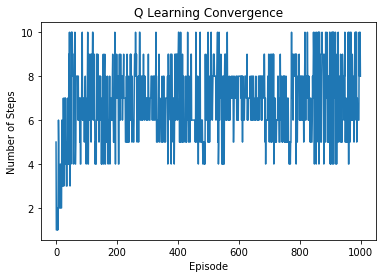

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()